In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rpy2
%load_ext rpy2.ipython

In [2]:
%%R
library(MASS)
library(dplyr)
library(forcats)
library(ggplot2)
library(patchwork)
library(Cairo)
library(broom)
library(tidyverse)
library(scales)

# http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

approachPalette <- c("GOMEA"="#56b4e9", "ECGA"="#009e73", "GA-UX"="#d55e00", "GA-TPX"="#e69f00", "GA-SFX"="#cc79a7")

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following object is masked from ‘package:MASS’:

    select


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘patchwork’


R[write to console]: The following object is masked from ‘package:MASS’:

    area


System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to connect to bus: Host is down


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8     ✔ purrr   0.3.5
✔ tidyr   1.2.1     ✔ stringr 1.5.0
✔ readr   2.1.3     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()


R[write to console]: 
Attaching package: ‘scales’


R[write to console]: The following object is masked from ‘package:purrr’:

    discard


R[write to console]: The following object is masked from ‘package:readr’:

    col_factor




In [3]:
%R names(approachPalette)

'GOMEA','ECGA','GA-UX','GA-TPX','GA-SFX'


In [4]:
date_of_processing = "2022-12-20"

In [5]:
results = pd.concat([
    pd.read_csv("2022-12-14-summary-trap.csv.gz"),
    pd.read_csv("2022-12-14-summary-nkl.csv.gz")
])
results["approach"] = pd.Categorical(results["approach"], ["GOMEA", "ECGA", "GA"])
results["timing"] = pd.Categorical(results["timing"], ["100:1", "10:1", "2:1", "1:1", "1:2", "1:10", "1:100"])
results["capped population size"] = np.where(np.isfinite(results["population_size"]), results["population_size"], results["population_size"].max() * 2)
# Numeric version
# results["timing"] = results["timing"].replace({
#     "100:1": 100/1,
#     "10:1": 10/1,
#     "2:1": 2/1,
#     "1:1": 1/1,
#     "1:2": 1/2,
#     "1:10": 1/10,
#     "1:100": 1/100
# }).astype(float)
# Cull extreme outliers
# results.loc[results["normalized population size"] > 10, "normalized population size"] = np.nan
# results.loc[results["normalized population size"] < -10, "normalized population size"] = np.nan
results = results.sort_values(["timing", "approach"])

In [6]:
results_trunc = results.copy()
with pd.option_context('mode.use_inf_as_null', True):
    popmax = results_trunc.dropna().groupby("problem")["normalized population size"].max().rename("problem max normalized population size").reset_index()
results_trunc = pd.merge(results_trunc, popmax)
results_trunc.loc[~np.isfinite(results_trunc["normalized population size"]), "normalized population size"] = results_trunc["problem max normalized population size"]

In [7]:
%R  names(approachPalette)

'GOMEA','ECGA','GA-UX','GA-TPX','GA-SFX'


Saving 5.56 x 4.17 in image
Saving 5.56 x 4.17 in image


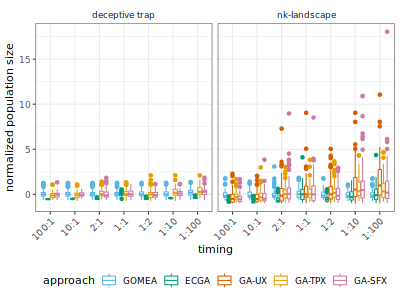

In [8]:
%%R -i date_of_processing -i results -w 400 -h 300
plt <- results %>%
    mutate(
  approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette))
) %>%
filter(`(a)sync` == "a" & (selection == "generational" | selection == "-")) %>%
    ggplot(aes(x=`timing`, y=`normalized population size`, color=`approach`)) +
    geom_boxplot() +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    facet_grid(. ~ `problem`) +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank())

fpath = paste(date_of_processing, "-plot-async-generational.eps", sep="")
ggsave(fpath, device = cairo_ps)
fpath = paste(date_of_processing, "-plot-async-generational.png", sep="")
ggsave(fpath, type = "cairo")
# embedFonts(fpath)
plt

Saving 5.56 x 4.17 in image
`geom_smooth()` using formula = 'y ~ x'
Saving 5.56 x 4.17 in image
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


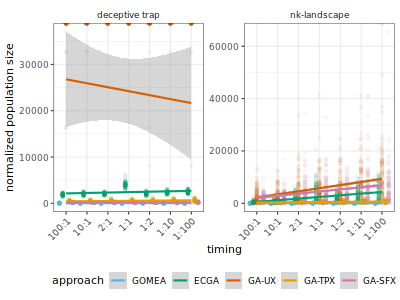

In [18]:
%%R -i date_of_processing -i results -w 400 -h 300
plt <- results %>%
    mutate(
  approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette))
) %>%
filter(`(a)sync` == "a" & (selection == "generational" | selection == "-")) %>%
    ggplot(aes(x=`timing`, y=`normalized population size`, color=`approach`, group=`approach`)) +
    geom_point(position=position_dodge(width=0.8), alpha=0.05) +
    geom_smooth(method="lm") +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    facet_wrap(. ~ `problem`, scales="free") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank())

fpath = paste(date_of_processing, "-plot-async-generational-scatter.eps", sep="")
ggsave(fpath, device = cairo_ps)
fpath = paste(date_of_processing, "-plot-async-generational-scatter.png", sep="")
ggsave(fpath, type = "cairo")
# embedFonts(fpath)
plt

Saving 5.56 x 4.17 in image
Saving 5.56 x 4.17 in image


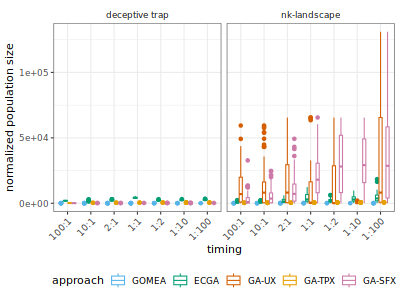

In [19]:
%%R -i date_of_processing -i results -w 400 -h 300
plt <- results %>%
    mutate(
  approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette))
) %>%
filter(`(a)sync` == "a" & (selection == "steady-state" | selection == "-")) %>%
    ggplot(aes(x=`timing`, y=`normalized population size`, color=`approach`)) +
    geom_boxplot() +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    facet_grid(. ~ `problem`) +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank())

fpath = paste(date_of_processing, "-plot-async-steady-state.eps", sep="")
ggsave(fpath, device = cairo_ps)
fpath = paste(date_of_processing, "-plot-async-steady-state.png", sep="")
ggsave(fpath, type = "cairo")
# embedFonts(fpath)
plt

Saving 5.56 x 4.17 in image
Saving 5.56 x 4.17 in image


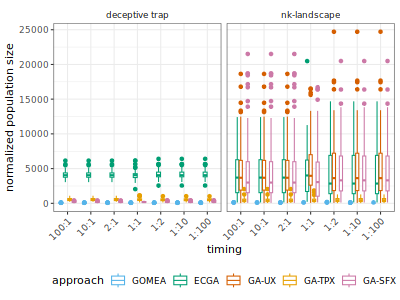

In [12]:
%%R -i date_of_processing -i results -w 400 -h 300
plt <- results %>%
    mutate(
  approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette))
) %>%
filter(`(a)sync` == "s" & (selection == "generational" | selection == "-")) %>%
    ggplot(aes(x=`timing`, y=`normalized population size`, color=`approach`)) +
    geom_boxplot() +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    facet_grid(. ~ `problem`) +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank())

fpath = paste(date_of_processing, "-plot-sync-generational.eps", sep="")
ggsave(fpath, device = cairo_ps)
fpath = paste(date_of_processing, "-plot-sync-generational.png", sep="")
ggsave(fpath, type = "cairo")
plt

Saving 5.56 x 4.17 in image
Saving 5.56 x 4.17 in image


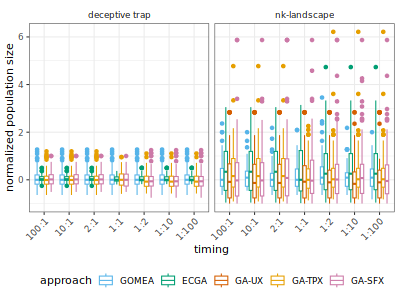

In [73]:
%%R -i date_of_processing -i results -w 400 -h 300
plt <- results %>%
    mutate(
  approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette))
) %>%
filter(`(a)sync` == "s" & (selection == "steady-state" | selection == "-")) %>%
    ggplot(aes(x=`timing`, y=`normalized population size`, color=`approach`)) +
    geom_boxplot() +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    facet_grid(. ~ `problem`) +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank())

fpath = paste(date_of_processing, "-plot-sync-steady-state.eps", sep="")
ggsave(fpath, device = cairo_ps)
fpath = paste(date_of_processing, "-plot-sync-steady-state.png", sep="")
ggsave(fpath, type = "cairo")
# embedFonts(fpath)
plt

Saving 5.56 x 4.17 in image
`geom_smooth()` using formula = 'y ~ x'
Saving 5.56 x 4.17 in image
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


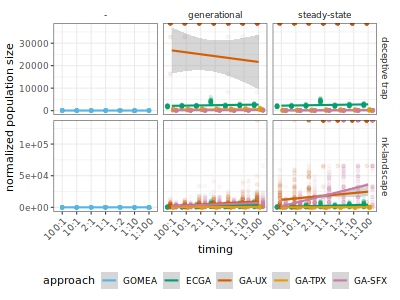

In [20]:
%%R -i date_of_processing -i results -w 400 -h 300
plt <- results %>%
    mutate(
  approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette))
) %>%
filter(`(a)sync` == "a") %>%
    ggplot(aes(x=`timing`, y=`normalized population size`, color=`approach`, group=`approach`)) +
    geom_point(position=position_dodge(width=0.8), alpha=0.05) +
    geom_smooth(method="lm") +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank())

fpath = paste(date_of_processing, "-plot-async-both-scatter.eps", sep="")
ggsave(fpath, device = cairo_ps)
fpath = paste(date_of_processing, "-plot-async-both-scatter.png", sep="")
ggsave(fpath, type = "cairo")
# embedFonts(fpath)
plt

Saving 5.56 x 4.17 in image
`geom_smooth()` using formula = 'y ~ x'
Saving 5.56 x 4.17 in image
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


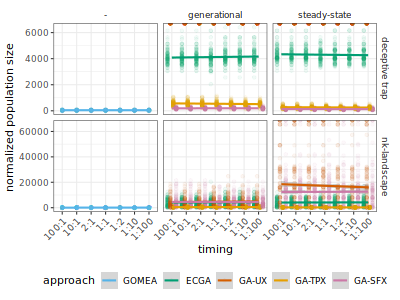

In [21]:
%%R -i date_of_processing -i results -w 400 -h 300
plt <- results %>%
    mutate(
  approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette))
) %>%
filter(`(a)sync` == "s") %>%
    ggplot(aes(x=`timing`, y=`normalized population size`, color=`approach`, group=`approach`)) +
    geom_point(position=position_dodge(width=0.8), alpha=0.05) +
    geom_smooth(method="lm") +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank())

fpath = paste(date_of_processing, "-plot-sync-both-scatter.eps", sep="")
ggsave(fpath, device = cairo_ps)
fpath = paste(date_of_processing, "-plot-sync-both-scatter.png", sep="")
ggsave(fpath, type = "cairo")
# embedFonts(fpath)
plt

In [22]:
results["success"] = np.isfinite(results["normalized population size"])
results.groupby(["problem", "approach", "cx", "selection", "(a)sync", "timing"])["success"].mean().dropna().reset_index().style

,problem,approach,cx,selection,(a)sync,timing,success
0,deceptive trap,GOMEA,-,-,a,100:1,1.000000
1,deceptive trap,GOMEA,-,-,a,10:1,1.000000
2,deceptive trap,GOMEA,-,-,a,2:1,1.000000
3,deceptive trap,GOMEA,-,-,a,1:1,1.000000
4,deceptive trap,GOMEA,-,-,a,1:2,1.000000
5,deceptive trap,GOMEA,-,-,a,1:10,1.000000
6,deceptive trap,GOMEA,-,-,a,1:100,1.000000
7,deceptive trap,GOMEA,-,-,s,100:1,1.000000
8,deceptive trap,GOMEA,-,-,s,10:1,1.000000
9,deceptive trap,GOMEA,-,-,s,2:1,1.000000


In [23]:
%%R -i results_trunc
#  -o r
r <- results_trunc %>%
    mutate(
            approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette))
        ) %>%
    mutate(
            timing = as.numeric(timing)
        ) %>%
    filter(`(a)sync` == "a") %>%
    group_by(`approach`, `problem`, `selection`) %>%
    do(model = lm(`timing` ~ `normalized population size`, data = .)) %>%
    mutate(tm = list(glance(model))) %>%
    unnest(tm)

r


# A tibble: 18 × 16
   approach problem     selec…¹ model r.squ…² adj.r.…³ sigma statis…⁴    p.value
   <fct>    <chr>       <chr>   <lis>   <dbl>    <dbl> <dbl>    <dbl>      <dbl>
 1 GOMEA    deceptive … -       <lm>  1.05e-2  0.00908  1.99  7.41e+0  6.66e-  3
 2 GOMEA    nk-landsca… -       <lm>  3.68e-5 -0.00140  2.00  2.57e-2  8.73e-  1
 3 ECGA     deceptive … genera… <lm>  5.77e-2  0.0564   1.94  4.28e+1  1.19e- 10
 4 ECGA     deceptive … steady… <lm>  5.66e-2  0.0552   1.95  4.18e+1  1.86e- 10
 5 ECGA     nk-landsca… genera… <lm>  2.22e-1  0.221    1.77  1.99e+2  6.19e- 40
 6 ECGA     nk-landsca… steady… <lm>  2.37e-1  0.235    1.75  2.16e+2  7.76e- 43
 7 GA-UX    deceptive … genera… <lm>  4.79e-5 -0.00138  2.00  3.35e-2  8.55e-  1
 8 GA-UX    deceptive … steady… <lm>  0        0        2.00 NA       NA        
 9 GA-UX    nk-landsca… genera… <lm>  1.01e-1  0.0996   1.90  7.84e+1  7.02e- 18
10 GA-UX    nk-landsca… steady… <lm>  5.91e-1  0.590    1.28  1.01e+3  1.26e-137
11 GA-TP

In [24]:
%%R

summary((r[1,]$`model`)[[1]])
# sapply(r, class)


Call:
lm(formula = timing ~ `normalized population size`, data = .)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.6642 -1.8574  0.0418  1.8905  3.3948 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  3.403529   0.231748  14.686  < 2e-16 ***
`normalized population size` 0.012607   0.004632   2.721  0.00666 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.992 on 698 degrees of freedom
Multiple R-squared:  0.0105,	Adjusted R-squared:  0.009082 
F-statistic: 7.406 on 1 and 698 DF,  p-value: 0.006661



In [25]:
%%R

# sapply(r, class)
summary((r[18,]$`model`)[[1]])


Call:
lm(formula = timing ~ `normalized population size`, data = .)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8319 -1.1913 -0.1774  0.7926  3.9995 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  3.000e+00  7.528e-02   39.85   <2e-16 ***
`normalized population size` 2.539e-05  1.190e-06   21.33   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.558 on 698 degrees of freedom
Multiple R-squared:  0.3947,	Adjusted R-squared:  0.3938 
F-statistic: 455.1 on 1 and 698 DF,  p-value: < 2.2e-16



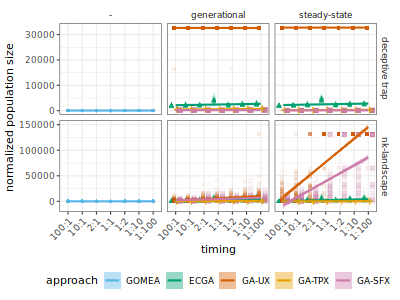

In [26]:
%%R -i date_of_processing -i results_trunc -w 400 -h 300
# Regression using some kind of exponential relationship
plt <- results_trunc %>%
    mutate(
  approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette))
) %>%
filter(`(a)sync` == "a") %>%
    ggplot(aes(x=`timing`, y=`normalized population size`, color=`approach`, fill=`approach`, shape=`approach`, group=`approach`)) +
    geom_point(position=position_dodge(width=0.8), alpha=0.05) +
    geom_smooth(method="lm", formula=y ~ x ) +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    scale_fill_manual(values=approachPalette, drop=FALSE) +
    # scale_y_continuous(trans='sqrt') +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank())

# fpath = paste(date_of_processing, "-plot-async-both-scatter.eps", sep="")
# ggsave(fpath, device = cairo_ps)
# fpath = paste(date_of_processing, "-plot-async-both-scatter.png", sep="")
# ggsave(fpath, type = "cairo")
# embedFonts(fpath)
plt

In [ ]:
%%R -i date_of_processing -i results_trunc -w 400 -h 300
# Regression using some kind of exponential relationship
plt <- results_trunc %>%
    mutate(
  approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette))
) %>%
filter(`(a)sync` == "a") %>%
    ggplot(aes(x=`timing`, y=`normalized population size`, color=`approach`, fill=`approach`, shape=`approach`, group=`approach`)) +
    geom_point(position=position_dodge(width=0.8), alpha=0.05) +
    geom_smooth(method="lm", formula=y ~ x ) +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    scale_fill_manual(values=approachPalette, drop=FALSE) +
    # scale_y_continuous(trans='sqrt') +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank())

# fpath = paste(date_of_processing, "-plot-async-both-scatter.eps", sep="")
# ggsave(fpath, device = cairo_ps)
# fpath = paste(date_of_processing, "-plot-async-both-scatter.png", sep="")
# ggsave(fpath, type = "cairo")
# embedFonts(fpath)
plt

Saving 5.56 x 4.17 in image


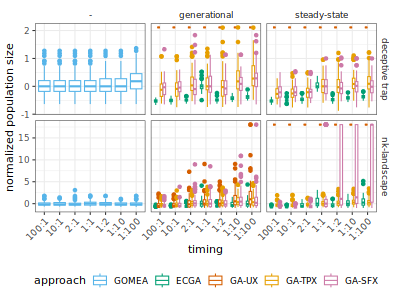

In [115]:
%%R -i date_of_processing -i results_trunc -w 400 -h 300
# Regression using some kind of exponential relationship
plt <- results_trunc %>%
    mutate(
  approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette))
) %>%
filter(`(a)sync` == "a") %>%
    ggplot(aes(x=`timing`, y=`normalized population size`, color=`approach`, shape=`approach`)) + #, fill=`approach`
    geom_boxplot() +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    scale_fill_manual(values=approachPalette, drop=FALSE) +
    # scale_y_continuous(trans='sqrt') +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank())

# fpath = paste(date_of_processing, "-plot-async-both-scatter.eps", sep="")
# ggsave(fpath, device = cairo_ps)
fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails.png", sep="")
ggsave(fpath, type = "cairo")
# embedFonts(fpath)
plt

Saving 5.56 x 4.17 in image


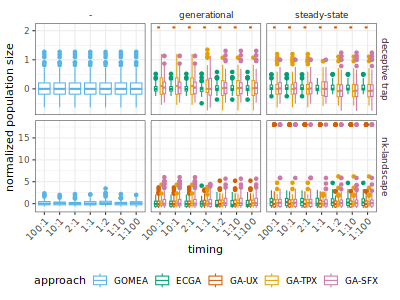

In [116]:
%%R -i date_of_processing -i results_trunc -w 400 -h 300
# Regression using some kind of exponential relationship
plt <- results_trunc %>%
    mutate(
      approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette))
    ) %>%
filter(`(a)sync` == "s") %>%
    ggplot(aes(x=`timing`, y=`normalized population size`, color=`approach`, shape=`approach`)) + #, fill=`approach`
    geom_boxplot() +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    scale_fill_manual(values=approachPalette, drop=FALSE) +
    # scale_y_continuous(trans='sqrt') +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank())

# fpath = paste(date_of_processing, "-plot-async-both-scatter.eps", sep="")
# ggsave(fpath, device = cairo_ps)
fpath = paste(date_of_processing, "-plot-sync-both-scatter-inc-fails.png", sep="")
ggsave(fpath, type = "cairo")
# embedFonts(fpath)
plt

Saving 5.56 x 4.17 in image


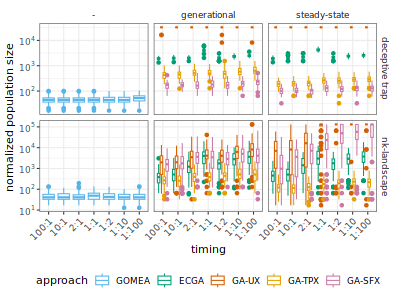

In [27]:
%%R -i date_of_processing -i results_trunc -w 400 -h 300
# Regression using some kind of exponential relationship
plt <- results_trunc %>%
    mutate(
      "normalized population size" = `normalized population size` + 1,
      approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette))
    ) %>%
filter(`(a)sync` == "a") %>%
    ggplot(aes(x=`timing`, y=`normalized population size`, color=`approach`, shape=`approach`)) + #, fill=`approach`
    geom_boxplot() +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    scale_fill_manual(values=approachPalette, drop=FALSE) +
    scale_y_continuous(trans='log10',
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank())

# fpath = paste(date_of_processing, "-plot-async-both-scatter.eps", sep="")
# ggsave(fpath, device = cairo_ps)
fpath = paste(date_of_processing, "-plot-async-both-box-inc-fails-log.png", sep="")
ggsave(fpath, type = "cairo")
# embedFonts(fpath)
plt

Saving 5.56 x 4.17 in image


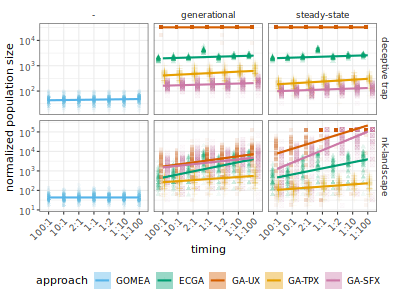

In [28]:
%%R -i date_of_processing -i results_trunc -w 400 -h 300
# Regression using some kind of exponential relationship
plt <- results_trunc %>%
    mutate(
      "normalized population size" = `normalized population size` + 1,
      approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette))
    ) %>%
filter(`(a)sync` == "a") %>%
    ggplot(aes(x=`timing`, y=`normalized population size`, color=`approach`, fill=`approach`, group=`approach`, shape=`approach`)) + #, fill=`approach`
    geom_point(position=position_dodge(width=0.8), alpha=0.05) +
    geom_smooth(method="rlm", formula=y ~ x) +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    scale_fill_manual(values=approachPalette, drop=FALSE) +
    scale_y_continuous(trans='log10',
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank())

# fpath = paste(date_of_processing, "-plot-async-both-scatter.eps", sep="")
# ggsave(fpath, device = cairo_ps)
fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log-robust.png", sep="")
ggsave(fpath, type = "cairo")
# embedFonts(fpath)
plt

Saving 13.9 x 5.56 in image
Saving 13.9 x 5.56 in image


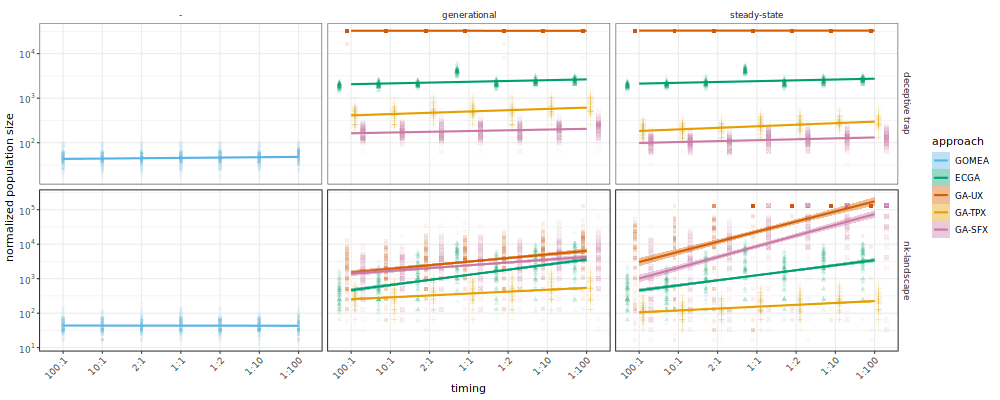

In [29]:
%%R -i date_of_processing -i results_trunc -w 1000 -h 400
# Regression using some kind of exponential relationship
plt <- results_trunc %>%
    mutate(
      "normalized population size" = `normalized population size` + 1,
      approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette))
    ) %>%
filter(`(a)sync` == "a") %>%
    ggplot(aes(x=`timing`, y=`normalized population size`, color=`approach`, fill=`approach`, group=`approach`, shape=`approach`)) + #, fill=`approach`
    geom_point(position=position_dodge(width=0.8), alpha=0.05) +
    geom_smooth(method="lm", formula=y ~ x, alpha=0.4) +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    scale_fill_manual(values=approachPalette, drop=FALSE) +
    scale_y_continuous(trans='log10',
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="right",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank())

fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.eps", sep="")
ggsave(fpath, device = cairo_ps)
fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.png", sep="")
ggsave(fpath, type = "cairo")
# embedFonts(fpath)
plt

Saving 13.9 x 5.56 in image
Saving 13.9 x 5.56 in image


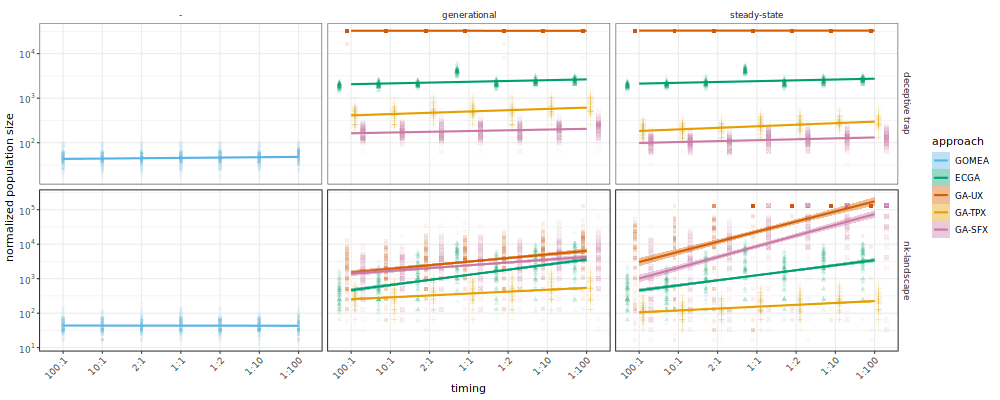

In [30]:
%%R -i date_of_processing -i results_trunc -w 1000 -h 400
# Regression using some kind of exponential relationship
plt <- results_trunc %>%
    mutate(
      "normalized population size" = `normalized population size` + 1,
      approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette))
    ) %>%
filter(`(a)sync` == "a") %>%
    ggplot(aes(x=`timing`, y=`normalized population size`, color=`approach`, fill=`approach`, group=`approach`, shape=`approach`)) + #, fill=`approach`
    geom_point(position=position_dodge(width=0.8), alpha=0.05) +
    geom_smooth(method="lm", formula=y ~ x, alpha=0.4) +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    scale_fill_manual(values=approachPalette, drop=FALSE) +
    scale_y_continuous(trans='log10',
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="right",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank())

fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.eps", sep="")
ggsave(fpath, device = cairo_ps)
fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.png", sep="")
ggsave(fpath, type = "cairo")
# embedFonts(fpath)
plt

Saving 13.9 x 3.47 in image
Saving 13.9 x 3.47 in image
Saving 13.9 x 3.47 in image
Saving 13.9 x 3.47 in image


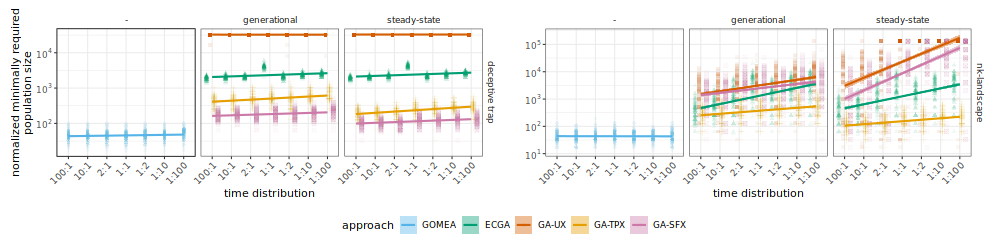

In [33]:
%%R -i date_of_processing -i results_trunc -w 1000 -h 250
# Regression using some kind of exponential relationship
plt1 <- results_trunc %>%
    mutate(
      "normalized population size" = `normalized population size` + 1,
      approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette))
    ) %>%
filter(`(a)sync` == "a" & `problem` == "deceptive trap") %>%
    ggplot(aes(x=`timing`, y=`normalized population size`, color=`approach`, fill=`approach`, group=`approach`, shape=`approach`)) + #, fill=`approach`
    geom_point(position=position_dodge(width=0.8), alpha=0.05) +
    geom_smooth(method="lm", formula=y ~ x, alpha=0.4) +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    scale_fill_manual(values=approachPalette, drop=FALSE) +
    scale_y_continuous(trans='log10',
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank()) +
      labs(x = "time distribution", y=str_wrap("normalized minimally required population size", width=30))
plt2 <- results_trunc %>%
    mutate(
      "normalized population size" = `normalized population size` + 1,
      approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette))
    ) %>%
filter(`(a)sync` == "a" & `problem` == "nk-landscape") %>%
    ggplot(aes(x=`timing`, y=`normalized population size`, color=`approach`, fill=`approach`, group=`approach`, shape=`approach`)) + #, fill=`approach`
    geom_point(position=position_dodge(width=0.8), alpha=0.05) +
    geom_smooth(method="lm", formula=y ~ x, alpha=0.4) +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    scale_fill_manual(values=approachPalette, drop=FALSE) +
    scale_y_continuous(trans='log10',
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank()) +
      labs(x = "time distribution", y="")
    

plt <- (plt1 | plt2) +
    plot_layout(guides = "collect") & theme(legend.position="bottom")

fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.eps", sep="")
ggsave(fpath, device = cairo_ps)
fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.pdf", sep="")
ggsave(fpath, device = cairo_pdf)
fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.png", sep="")
ggsave(fpath, type = "cairo")
fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.svg", sep="")
ggsave(fpath)
# embedFonts(fpath)
plt

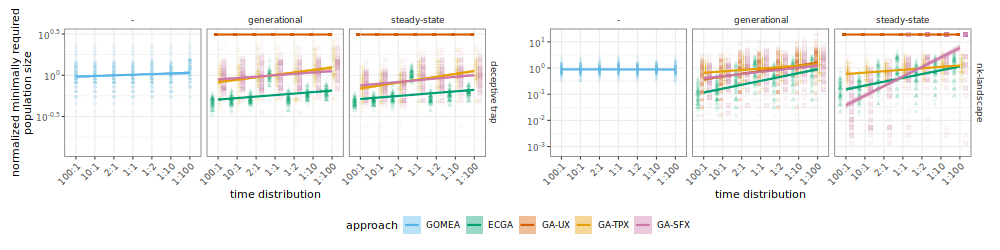

In [8]:
%%R -i date_of_processing -i results_trunc -w 1000 -h 250
# Regression using some kind of exponential relationship
plt1 <- results_trunc %>%
    mutate(
      "normalized population size" = `normalized population size` + 1,
      approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette))
    ) %>%
filter(`(a)sync` == "a" & `problem` == "deceptive trap") %>%
    ggplot(aes(x=`timing`, y=`normalized population size`, color=`approach`, fill=`approach`, group=`approach`, shape=`approach`)) + #, fill=`approach`
    geom_point(position=position_dodge(width=0.8), alpha=0.05) +
    geom_smooth(method="lm", formula=y ~ x, alpha=0.4) +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    scale_fill_manual(values=approachPalette, drop=FALSE) +
    scale_y_continuous(trans='log10',
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank()) +
      labs(x = "time distribution", y=str_wrap("normalized minimally required population size", width=30))
plt2 <- results_trunc %>%
    mutate(
      "normalized population size" = `normalized population size` + 1,
      approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette))
    ) %>%
filter(`(a)sync` == "a" & `problem` == "nk-landscape") %>%
    ggplot(aes(x=`timing`, y=`normalized population size`, color=`approach`, fill=`approach`, group=`approach`, shape=`approach`)) + #, fill=`approach`
    geom_point(position=position_dodge(width=0.8), alpha=0.05) +
    geom_smooth(method="lm", formula=y ~ x, alpha=0.4) +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    scale_fill_manual(values=approachPalette, drop=FALSE) +
    scale_y_continuous(trans='log10',
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank()) +
      labs(x = "time distribution", y="")
    

plt <- (plt1 | plt2) +
    plot_layout(guides = "collect") & theme(legend.position="bottom")

# fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.eps", sep="")
# ggsave(fpath, device = cairo_ps)
# fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.pdf", sep="")
# ggsave(fpath, device = cairo_pdf)
# fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.png", sep="")
# ggsave(fpath, type = "cairo")
# fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.svg", sep="")
# ggsave(fpath)
# # embedFonts(fpath)
plt

Saving 13.9 x 3.47 in image
Saving 13.9 x 3.47 in image
Saving 13.9 x 3.47 in image
Saving 13.9 x 3.47 in image


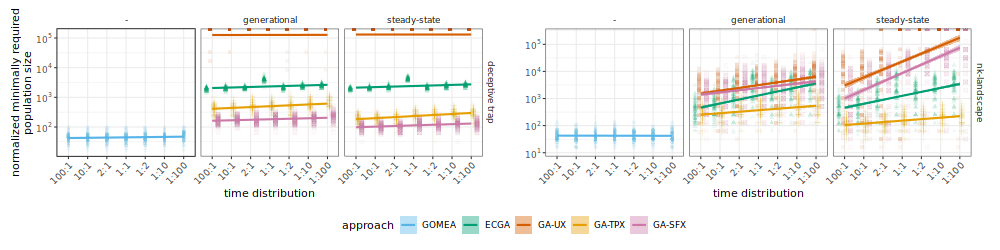

In [85]:
%%R -i date_of_processing -i results_trunc -w 1000 -h 250

maxpopsize <- results_trunc %>%
    select(`capped population size`) %>%
    filter(is.finite(`capped population size`)) %>%
    summarize(max(`capped population size`)) %>%
    pull


result_proc <- results_trunc %>%
    mutate(
      "capped population size c"=ifelse(is.finite(`capped population size`), `capped population size`, maxpopsize),
      approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette))
    )
# Regression using some kind of exponential relationship
plt1 <- result_proc %>%
filter(`(a)sync` == "a" & `problem` == "deceptive trap") %>%
    ggplot(aes(x=`timing`, y=`capped population size`, color=`approach`, fill=`approach`, group=`approach`, shape=`approach`)) + #, fill=`approach`
    geom_point(position=position_dodge(width=0.8), alpha=0.05) +
    geom_smooth(method="lm", formula=y ~ x, alpha=0.4, aes(y=`capped population size c`)) +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    scale_fill_manual(values=approachPalette, drop=FALSE) +
    scale_y_continuous(trans='log10',
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank()) +
      labs(x = "time distribution", y=str_wrap("normalized minimally required population size", width=30))
plt2 <- result_proc %>%
filter(`(a)sync` == "a" & `problem` == "nk-landscape") %>%
    ggplot(aes(x=`timing`, y=`capped population size`, color=`approach`, fill=`approach`, group=`approach`, shape=`approach`)) + #, fill=`approach`
    geom_point(position=position_dodge(width=0.8), alpha=0.05) +
    geom_smooth(method="lm", formula=y ~ x, alpha=0.4, aes(y=`capped population size c`)) +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    scale_fill_manual(values=approachPalette, drop=FALSE) +
    scale_y_continuous(trans='log10',
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank()) +
      labs(x = "time distribution", y="")
    

plt <- (plt1 | plt2) +
    plot_layout(guides = "collect") & theme(legend.position="bottom")

fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.eps", sep="")
ggsave(fpath, device = cairo_ps)
fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.pdf", sep="")
ggsave(fpath, device = cairo_pdf)
fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.png", sep="")
ggsave(fpath, type = "cairo")
fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.svg", sep="")
ggsave(fpath)
# embedFonts(fpath)
plt

In [96]:
results_trunc

,Unnamed: 0,problem,timing,population_size,normalized population size,approach,cx,(a)sync,selection,capped population size,problem max normalized population size
0,974,deceptive trap,100:1,44.0,0.000000,GOMEA,-,s,-,44.0,2.112903
1,973,deceptive trap,100:1,48.0,0.090909,GOMEA,-,s,-,48.0,2.112903
2,972,deceptive trap,100:1,56.0,0.272727,GOMEA,-,s,-,56.0,2.112903
3,971,deceptive trap,100:1,48.0,0.090909,GOMEA,-,s,-,48.0,2.112903
4,970,deceptive trap,100:1,56.0,0.272727,GOMEA,-,s,-,56.0,2.112903
...,...,...,...,...,...,...,...,...,...,...,...
25195,6997,nk-landscape,1:100,16248.0,-0.049713,GA,UX,s,steady-state,16248.0,18.040093
25196,6998,nk-landscape,1:100,64.0,-0.996257,GA,UX,s,steady-state,64.0,18.040093
25197,6999,nk-landscape,1:100,57344.0,2.353843,GA,UX,s,steady-state,57344.0,18.040093
25198,6996,nk-landscape,1:100,30720.0,0.796701,GA,UX,s,steady-state,30720.0,18.040093


In [20]:
%%R -o results_succ

results_succ <- results_trunc %>%
    mutate(
      approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette))
    ) %>%
    group_by(`approach`, `problem`, `timing`, `(a)sync`) %>%
    summarize("success ratio"=sum(is.finite(`population_size`)) / n())
results_succ

`summarise()` has grouped output by 'approach', 'problem', 'timing'. You can
override using the `.groups` argument.
# A tibble: 140 × 5
# Groups:   approach, problem, timing [70]
   approach problem        timing `(a)sync` `success ratio`
   <fct>    <chr>          <fct>  <chr>               <dbl>
 1 GOMEA    deceptive trap 100:1  a                       1
 2 GOMEA    deceptive trap 100:1  s                       1
 3 GOMEA    deceptive trap 10:1   a                       1
 4 GOMEA    deceptive trap 10:1   s                       1
 5 GOMEA    deceptive trap 2:1    a                       1
 6 GOMEA    deceptive trap 2:1    s                       1
 7 GOMEA    deceptive trap 1:1    a                       1
 8 GOMEA    deceptive trap 1:1    s                       1
 9 GOMEA    deceptive trap 1:2    a                       1
10 GOMEA    deceptive trap 1:2    s                       1
# … with 130 more rows
# ℹ Use `print(n = ...)` to see more rows


`summarise()` has grouped output by 'approach', 'problem', 'timing'. You can
override using the `.groups` argument.
Joining, by = c("problem", "timing", "approach", "(a)sync")


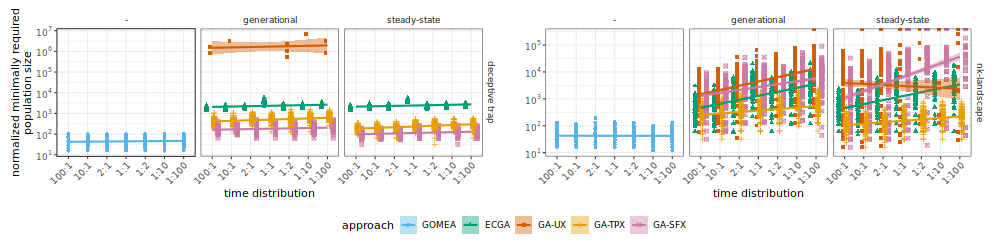

In [27]:
%%R -i date_of_processing -i results_trunc -w 1000 -h 250

# What we want: population size * probability of success for a configuration

results_trunc2 <- results_trunc %>%
    mutate(
      approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette))
    )

# Compute success rate
results_succ <- results_trunc2 %>%
    group_by(`approach`, `problem`, `timing`, `(a)sync`) %>%
    summarize("success ratio"=sum(is.finite(`population_size`)) / n())


# Join & compute effective success rate
results_eff <- left_join(results_trunc2, results_succ) %>%
    mutate("effective required population size"=`population_size`/`success ratio`)

# maxpopsize <- results_trunc %>%
#     select(`capped population size`) %>%
#     filter(is.finite(`capped population size`)) %>%
#     summarize(max(`capped population size`)) %>%
#     pull

# Regression using some kind of exponential relationship
plt1 <- results_eff %>%
filter(`(a)sync` == "a" & `problem` == "deceptive trap") %>%
    ggplot(aes(x=`timing`, y=`effective required population size`, color=`approach`, fill=`approach`, group=`approach`, shape=`approach`)) + #, fill=`approach`
    geom_point(position=position_dodge(width=0.8), alpha=1.0) +
    geom_smooth(method="lm", formula=y ~ x + x^2, alpha=0.4, aes(y=`effective required population size`)) +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    scale_fill_manual(values=approachPalette, drop=FALSE) +
    scale_y_continuous(trans='log10',
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank()) +
      labs(x = "time distribution", y=str_wrap("normalized minimally required population size", width=30))
plt2 <- results_eff %>%
filter(`(a)sync` == "a" & `problem` == "nk-landscape") %>%
    ggplot(aes(x=`timing`, y=`effective required population size`, color=`approach`, fill=`approach`, group=`approach`, shape=`approach`)) + #, fill=`approach`
    geom_point(position=position_dodge(width=0.8), alpha=1.0) +
    geom_smooth(method="lm", formula=y ~ x + x^2, alpha=0.4, aes(y=`effective required population size`)) +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    scale_fill_manual(values=approachPalette, drop=FALSE) +
    scale_y_continuous(trans='log10',
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank()) +
      labs(x = "time distribution", y="")
    

plt <- (plt1 | plt2) +
    plot_layout(guides = "collect") & theme(legend.position="bottom")

# fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.eps", sep="")
# ggsave(fpath, device = cairo_ps)
# fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.pdf", sep="")
# ggsave(fpath, device = cairo_pdf)
# fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.png", sep="")
# ggsave(fpath, type = "cairo")
# fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.svg", sep="")
# ggsave(fpath)
# embedFonts(fpath)
plt

`summarise()` has grouped output by 'approach', 'problem', 'timing',
'selection'. You can override using the `.groups` argument.
Joining, by = c("problem", "timing", "approach", "(a)sync", "selection")
Saving 13.9 x 3.47 in image
Saving 13.9 x 3.47 in image
Saving 13.9 x 3.47 in image
Saving 13.9 x 3.47 in image


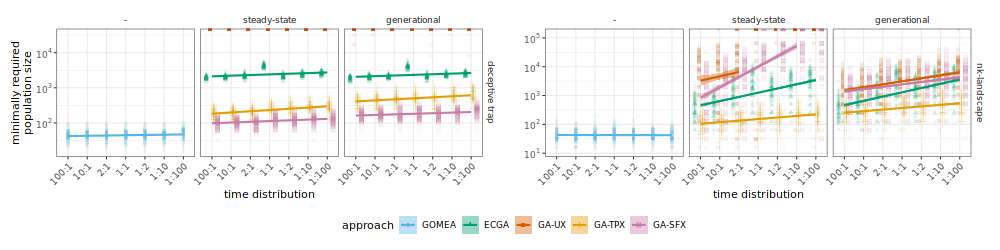

In [8]:
%%R -i date_of_processing -i results_trunc -w 1000 -h 250

min_success_rate_for_regression = 0.50
results_trunc2 <- results_trunc %>%
    mutate(
      approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette))
    )

# Compute success rate
results_succ <- results_trunc2 %>%
    group_by(`approach`, `problem`, `timing`, `selection`, `(a)sync`) %>%
    summarize("success ratio"=mean(is.finite(`population_size`)))

maxpopsize <- results_trunc %>%
    select(`capped population size`) %>%
    filter(is.finite(`capped population size`)) %>%
    summarize(max(`capped population size`)) %>%
    pull

# Join & compute effective success rate
results_eff <- left_join(results_trunc2, results_succ) %>%
    mutate(
        "effective required population size"=`population_size`/`success ratio`,
        "population size"=ifelse(is.finite(`population_size`), `population_size`, Inf),
        "population size if reasonable"=ifelse(`success ratio` > min_success_rate_for_regression, 
            ifelse(is.finite(`population_size`), `population_size`, maxpopsize), Inf),
        "selection"=factor(`selection`, levels=c("-", "steady-state", "generational"))
        )

plt1 <- results_eff %>%
filter(`(a)sync` == "a" & `problem` == "deceptive trap") %>%
    ggplot(aes(x=`timing`, y=`population size`, color=`approach`, fill=`approach`, group=`approach`, shape=`approach`)) + #, fill=`approach`
    geom_point(aes(alpha='c'), position=position_dodge(width=0.8)) +
    geom_smooth(method="lm", formula=y ~ x, alpha=0.4, aes(y=`population size if reasonable`)) +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    scale_fill_manual(values=approachPalette, drop=FALSE) +
    scale_alpha_manual(values=c(0.05)) + guides(alpha='none') +
    scale_y_continuous(trans='log10',
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank()) +
      labs(x = "time distribution", y=str_wrap("minimally required population size", width=20))

plt2 <- results_eff %>%
filter(`(a)sync` == "a" & `problem` == "nk-landscape") %>%
    ggplot(aes(x=`timing`, y=`population size`, color=`approach`, fill=`approach`, group=`approach`, shape=`approach`)) + #, fill=`approach`
    geom_point(aes(alpha='c'), position=position_dodge(width=0.8)) +
    geom_smooth(method="lm", formula=y ~ x, alpha=0.4, aes(y=`population size if reasonable`)) +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    scale_fill_manual(values=approachPalette, drop=FALSE) +
    scale_alpha_manual(values=c(0.05)) + guides(alpha='none') +
    scale_y_continuous(trans='log10',
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank()) +
      labs(x = "time distribution", y="")
    

plt <- (plt1 | plt2) +
    plot_layout(guides = "collect") & theme(legend.position="bottom")

fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.eps", sep="")
ggsave(fpath, device = cairo_ps)
fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.pdf", sep="")
ggsave(fpath, device = cairo_pdf)
fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.png", sep="")
ggsave(fpath, type = "cairo")
fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.svg", sep="")
ggsave(fpath)
# embedFonts(fpath)
plt

`summarise()` has grouped output by 'approach', 'problem', 'timing',
'selection'. You can override using the `.groups` argument.
Joining, by = c("problem", "timing", "approach", "(a)sync", "selection")
Saving 13.9 x 3.47 in image
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
Saving 13.9 x 3.47 in image
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


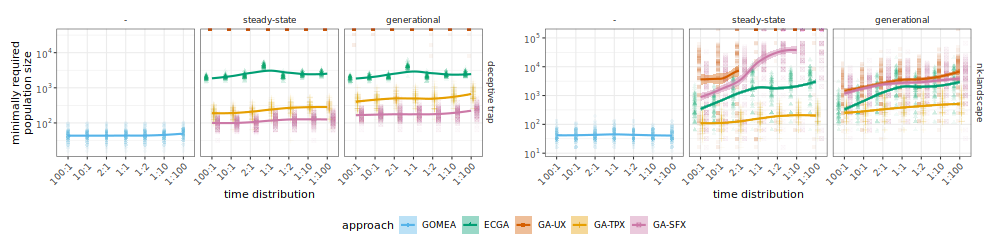

In [9]:
%%R -i date_of_processing -i results_trunc -w 1000 -h 250

min_success_rate_for_regression = 0.50
results_trunc2 <- results_trunc %>%
    mutate(
      approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette))
    )

# Compute success rate
results_succ <- results_trunc2 %>%
    group_by(`approach`, `problem`, `timing`, `selection`, `(a)sync`) %>%
    summarize("success ratio"=mean(is.finite(`population_size`)))

maxpopsize <- results_trunc %>%
    select(`capped population size`) %>%
    filter(is.finite(`capped population size`)) %>%
    summarize(max(`capped population size`)) %>%
    pull

# Join & compute effective success rate
results_eff <- left_join(results_trunc2, results_succ) %>%
    mutate(
        "effective required population size"=`population_size`/`success ratio`,
        "population size"=ifelse(is.finite(`population_size`), `population_size`, Inf),
        "population size if reasonable"=ifelse(`success ratio` > min_success_rate_for_regression, 
            ifelse(is.finite(`population_size`), `population_size`, maxpopsize), Inf),
        "selection"=factor(`selection`, levels=c("-", "steady-state", "generational"))
        )

plt1 <- results_eff %>%
filter(`(a)sync` == "a" & `problem` == "deceptive trap") %>%
    ggplot(aes(x=`timing`, y=`population size`, color=`approach`, fill=`approach`, group=`approach`, shape=`approach`)) + #, fill=`approach`
    geom_point(aes(alpha='c'), position=position_dodge(width=0.8)) +
    geom_smooth(method="loess", alpha=0.4, aes(y=`population size if reasonable`)) +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    scale_fill_manual(values=approachPalette, drop=FALSE) +
    scale_alpha_manual(values=c(0.05)) + guides(alpha='none') +
    scale_y_continuous(trans='log10',
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank()) +
      labs(x = "time distribution", y=str_wrap("minimally required population size", width=20))

plt2 <- results_eff %>%
filter(`(a)sync` == "a" & `problem` == "nk-landscape") %>%
    ggplot(aes(x=`timing`, y=`population size`, color=`approach`, fill=`approach`, group=`approach`, shape=`approach`)) + #, fill=`approach`
    geom_point(aes(alpha='c'), position=position_dodge(width=0.8)) +
    geom_smooth(method="loess", alpha=0.4, aes(y=`population size if reasonable`)) +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    scale_fill_manual(values=approachPalette, drop=FALSE) +
    scale_alpha_manual(values=c(0.05)) + guides(alpha='none') +
    scale_y_continuous(trans='log10',
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank()) +
      labs(x = "time distribution", y="")
    

plt <- (plt1 | plt2) +
    plot_layout(guides = "collect") & theme(legend.position="bottom")

# fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log-loess.eps", sep="")
# ggsave(fpath, device = cairo_ps)
fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log-loess.pdf", sep="")
ggsave(fpath, device = cairo_pdf)
fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log-loess.png", sep="")
ggsave(fpath, type = "cairo")
# fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log-loess.svg", sep="")
# ggsave(fpath)
# embedFonts(fpath)
plt

`summarise()` has grouped output by 'approach', 'problem', 'timing',
'selection'. You can override using the `.groups` argument.
Joining, by = c("problem", "timing", "approach", "(a)sync", "selection")


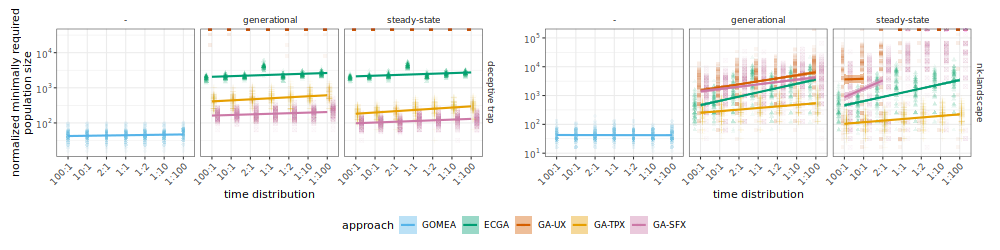

In [22]:
%%R -i date_of_processing -i results_trunc -w 1000 -h 250

# Checking out alternative levels of success rates.
min_success_rate_for_regression = 0.95
results_trunc2 <- results_trunc %>%
    mutate(
      approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette))
    )

# Compute success rate
results_succ <- results_trunc2 %>%
    group_by(`approach`, `problem`, `timing`, `selection`, `(a)sync`) %>%
    summarize("success ratio"=mean(is.finite(`population_size`)))

maxpopsize <- results_trunc %>%
    select(`capped population size`) %>%
    filter(is.finite(`capped population size`)) %>%
    summarize(max(`capped population size`)) %>%
    pull

# Join & compute effective success rate
results_eff <- left_join(results_trunc2, results_succ) %>%
    mutate(
        "effective required population size"=`population_size`/`success ratio`,
        "population size"=ifelse(is.finite(`population_size`), `population_size`, Inf),
        "population size if reasonable"=ifelse(`success ratio` > min_success_rate_for_regression, 
            ifelse(is.finite(`population_size`), `population_size`, maxpopsize), Inf)
        )

plt1 <- results_eff %>%
filter(`(a)sync` == "a" & `problem` == "deceptive trap") %>%
    ggplot(aes(x=`timing`, y=`population size`, color=`approach`, fill=`approach`, group=`approach`, shape=`approach`)) + #, fill=`approach`
    geom_point(position=position_dodge(width=0.8), alpha=0.05) +
    geom_smooth(method="lm", formula=y ~ x + x^2, alpha=0.4, aes(y=`population size if reasonable`)) +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    scale_fill_manual(values=approachPalette, drop=FALSE) +
    scale_y_continuous(trans='log10',
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank()) +
      labs(x = "time distribution", y=str_wrap("normalized minimally required population size", width=30))

plt2 <- results_eff %>%
filter(`(a)sync` == "a" & `problem` == "nk-landscape") %>%
    ggplot(aes(x=`timing`, y=`population size`, color=`approach`, fill=`approach`, group=`approach`, shape=`approach`)) + #, fill=`approach`
    geom_point(position=position_dodge(width=0.8), alpha=0.05) +
    geom_smooth(method="lm", formula=y ~ x + x^2, alpha=0.4, aes(y=`population size if reasonable`)) +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    scale_fill_manual(values=approachPalette, drop=FALSE) +
    scale_y_continuous(trans='log10',
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank()) +
      labs(x = "time distribution", y="")
    

plt <- (plt1 | plt2) +
    plot_layout(guides = "collect") & theme(legend.position="bottom")

# fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.eps", sep="")
# ggsave(fpath, device = cairo_ps)
# fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.pdf", sep="")
# ggsave(fpath, device = cairo_pdf)
# fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.png", sep="")
# ggsave(fpath, type = "cairo")
# fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log.svg", sep="")
# ggsave(fpath)
# embedFonts(fpath)
plt

`summarise()` has grouped output by 'approach', 'problem', 'selection',
'timing'. You can override using the `.groups` argument.
Joining, by = c("problem", "timing", "approach", "(a)sync", "selection")
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


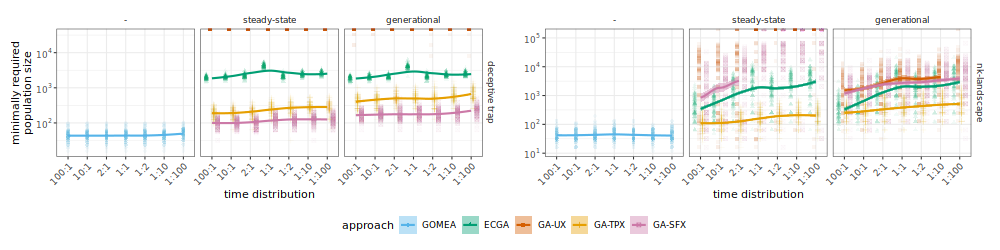

In [26]:
%%R -i date_of_processing -i results_trunc -w 1000 -h 250

min_success_rate_for_regression = 0.99
results_trunc2 <- results_trunc %>%
    mutate(
      approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette))
    )

# Compute success rate
results_succ <- results_trunc2 %>%
    group_by(`approach`, `problem`, `selection`, `timing`, `(a)sync`) %>%
    summarize("success ratio"=mean(is.finite(`population_size`)))

maxpopsize <- results_trunc %>%
    select(`capped population size`) %>%
    filter(is.finite(`capped population size`)) %>%
    summarize(max(`capped population size`)) %>%
    pull

# Join & compute effective success rate
results_eff <- left_join(results_trunc2, results_succ) %>%
    mutate(
        "effective required population size"=`population_size`/`success ratio`,
        "population size"=ifelse(is.finite(`population_size`), `population_size`, Inf),
        # "population size if reasonable"=ifelse(`success ratio` > min_success_rate_for_regression, 
        #     ifelse(is.finite(`population_size`), `population_size`, maxpopsize), Inf),
        "population size if reasonable"=ifelse(`success ratio` > min_success_rate_for_regression, 
            ifelse(is.finite(`population_size`), `population_size`, 2 * maxpopsize), Inf),
        "selection"=factor(`selection`, levels=c("-", "steady-state", "generational"))
        )

plt1 <- results_eff %>%
filter(`(a)sync` == "a" & `problem` == "deceptive trap") %>%
    ggplot(aes(x=`timing`, y=`population size`, color=`approach`, fill=`approach`, group=`approach`, shape=`approach`)) + #, fill=`approach`
    geom_point(aes(alpha='c'), position=position_dodge(width=0.8)) +
    geom_smooth(method="loess", alpha=0.4, aes(y=`population size if reasonable`)) +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    scale_fill_manual(values=approachPalette, drop=FALSE) +
    scale_alpha_manual(values=c(0.05)) + guides(alpha='none') +
    scale_y_continuous(trans='log10',
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank()) +
      labs(x = "time distribution", y=str_wrap("minimally required population size", width=20))

plt2 <- results_eff %>%
filter(`(a)sync` == "a" & `problem` == "nk-landscape") %>%
    ggplot(aes(x=`timing`, y=`population size`, color=`approach`, fill=`approach`, group=`approach`, shape=`approach`)) + #, fill=`approach`
    geom_point(aes(alpha='c'), position=position_dodge(width=0.8)) +
    geom_smooth(method="loess", alpha=0.4, aes(y=`population size if reasonable`)) +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    scale_fill_manual(values=approachPalette, drop=FALSE) +
    scale_alpha_manual(values=c(0.05)) + guides(alpha='none') +
    scale_y_continuous(trans='log10',
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank()) +
      labs(x = "time distribution", y="")
    

plt <- (plt1 | plt2) +
    plot_layout(guides = "collect") & theme(legend.position="bottom")

# fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log-loess.eps", sep="")
# ggsave(fpath, device = cairo_ps)
# fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log-loess.pdf", sep="")
# ggsave(fpath, device = cairo_pdf)
# fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log-loess.png", sep="")
# ggsave(fpath, type = "cairo")
# fpath = paste(date_of_processing, "-plot-async-both-scatter-inc-fails-log-loess.svg", sep="")
# ggsave(fpath)
# embedFonts(fpath)
plt

Annoyingly, some runs failed, so the effective population size for them is infinity. Sadly, that does not get accounted for by the regressor, providing a line with negative slope. The plot above sets them to the maximum population size that was successful during the runs, which allows them to be accounted for, though realistically - these runs have failed(!) and giving them the maximum population size tested still underestimates the effect.

The following bit approaches this problem slightly differently: each of the runs samples another point from the same subset and adds it to the population size if it was a failed run. If the sampled run failed, the resulting run is failed too, otherwise the resulting run is successful.
Repeat this operation a few times to estimate by repeated running.

The resulting population size will scale according to the probability of failure, and thus be more realistic.

(array([   0., 3573., 2908., 1713.,  901.,  445.,  272.,   97.,   49.,
          23.,   11.,    5.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5]),
 <BarContainer object of 12 artists>)

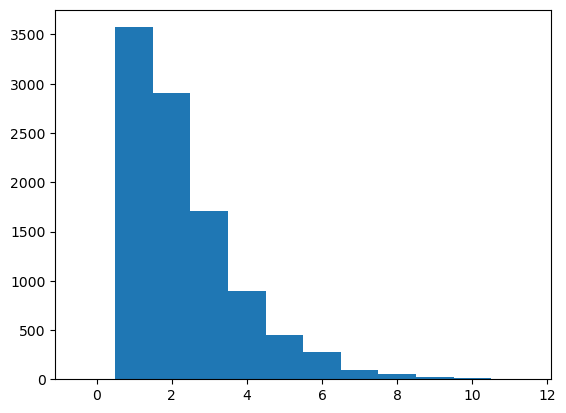

In [16]:
# incremental
seed = 42
rng = np.random.default_rng(seed=seed)
Ps = 0.6
s = 10000
success = rng.choice((0, 1), size=s, p=(1-Ps, Ps))
value = np.ones(s)

orig_success = success.copy()
orig_value = value.copy()

num_iter = 0
max_iter = 200
while num_iter < max_iter and (success >= 1).sum() < s:
    indices = rng.choice(s, size=s)
    success += orig_success[indices]
    # add value if we were previously not successful.
    value += np.where(success < 2, orig_value[indices], 0)
    num_iter += 1
plt.hist(value, bins=[i - 0.5 for i in range(int(max(value)) + 1)])


In [9]:
%%R -i date_of_processing -i results_trunc -o results_trunc2 -w 1000 -h 250
maxpopsize <- results_trunc %>%
    select(`capped population size`) %>%
    filter(is.finite(`capped population size`)) %>%
    summarize(max(`capped population size`)) %>%
    pull

results_trunc2 <- results_trunc %>%
    mutate(
      approach = factor(gsub("--", "", paste(approach, cx, sep = "-")), levels=names(approachPalette)),
      "success" = is.finite(`population_size`),
      "population size"=ifelse(is.finite(`population_size`), `population_size`, maxpopsize)
    )

# # Compute success rate, if it is 0, the value is truly infinite (!)
# results_succ <- results_trunc2 %>%
#     group_by(`approach`, `problem`, `timing`, `(a)sync`) %>%
#     summarize("success ratio"=sum(is.finite(`population_size`)) / n()) %>%
#     mutate("num iters est"=log(0.05)/log(1-`success ratio`))
# results_succ

In [20]:
results_trunc2.groupby(["approach", "problem", "timing", "(a)sync", "selection"])["success"].mean().reset_index().style

,approach,problem,timing,(a)sync,selection,success
0,1,deceptive trap,1,a,-,1.000000
1,1,deceptive trap,1,s,-,1.000000
2,1,deceptive trap,2,a,-,1.000000
3,1,deceptive trap,2,s,-,1.000000
4,1,deceptive trap,3,a,-,1.000000
5,1,deceptive trap,3,s,-,1.000000
6,1,deceptive trap,4,a,-,1.000000
7,1,deceptive trap,4,s,-,1.000000
8,1,deceptive trap,5,a,-,1.000000
9,1,deceptive trap,5,s,-,1.000000


In [10]:
def accumulative_successful_sampling(success, value):
    # incremental
    seed = 42
    rng = np.random.default_rng(seed=seed)
    # Ps = 0.6
    # s = 10000
    s = len(success)
    # success = rng.choice((0, 1), size=s, p=(1-Ps, Ps))
    # value = np.ones(s)

    orig_success = success.copy()
    orig_value = value.copy()

    num_iter = 0
    max_iter = 200
    while num_iter < max_iter and (success >= 1).sum() < s:
        indices = rng.choice(s, size=s)
        success += orig_success[indices]
        # add value if we were previously not successful.
        value += np.where(success < 2, orig_value[indices], 0)
        num_iter += 1
    
    return dict(success=success, value=value)
    

In [17]:
results_sampl = results_trunc2.groupby(["approach", "problem", "timing", "(a)sync", "selection"]).apply(lambda df: accumulative_successful_sampling(df["success"].to_numpy(), df["population size"].to_numpy())["value"]).rename("population size").explode().reset_index()
results_sampl["population size"] = results_sampl["population size"].astype('int')

NameError: name 'results_trunc2' is not defined

Saving 13.9 x 3.47 in image
Saving 13.9 x 3.47 in image
Saving 13.9 x 3.47 in image
Saving 13.9 x 3.47 in image


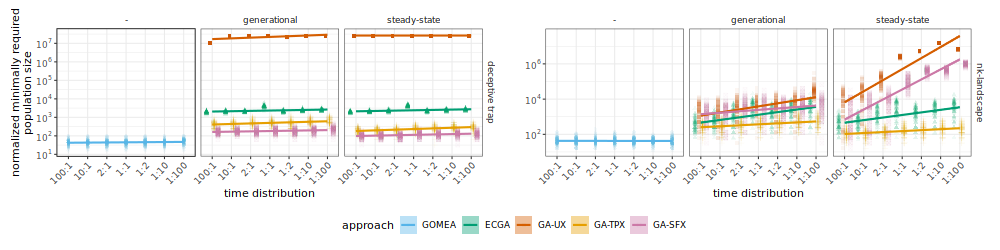

In [19]:
%%R -i date_of_processing -i results_sampl -w 1000 -h 250

# What we want: population size * probability of success for a configuration

results_sampl$`approach` = factor(results_sampl$`approach`, labels=names(approachPalette))
results_sampl$`timing` = factor(results_sampl$`timing`, labels=levels(results_trunc2$`timing`))

plt1 <- results_sampl %>%
filter(`(a)sync` == "a" & `problem` == "deceptive trap") %>%
    ggplot(aes(x=`timing`, y=`population size`, color=`approach`, fill=`approach`, group=`approach`, shape=`approach`)) + #, fill=`approach`
    geom_point(position=position_dodge(width=0.8), alpha=0.05) +
    geom_smooth(method="lm", formula=y ~ x + x^2, alpha=0.4, aes(y=`population size`)) +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    scale_fill_manual(values=approachPalette, drop=FALSE) +
    scale_y_continuous(trans='log10',
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank()) +
      labs(x = "time distribution", y=str_wrap("normalized minimally required population size", width=30))

plt2 <- results_sampl %>%
filter(`(a)sync` == "a" & `problem` == "nk-landscape") %>%
    ggplot(aes(x=`timing`, y=`population size`, color=`approach`, fill=`approach`, group=`approach`, shape=`approach`)) + #, fill=`approach`
    geom_point(position=position_dodge(width=0.8), alpha=0.05) +
    geom_smooth(method="lm", formula=y ~ x + x^2, alpha=0.4, aes(y=`population size`)) +
    scale_color_manual(values=approachPalette, drop=FALSE) +
    scale_fill_manual(values=approachPalette, drop=FALSE) +
    scale_y_continuous(trans='log10',
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
    facet_grid(`problem` ~ selection, scales="free") +
    theme_bw() +
    theme(
      legend.position="bottom",
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1),
      plot.background = element_rect(fill='transparent', color=NA),
      strip.background = element_blank()) +
      labs(x = "time distribution", y="")
    

plt <- (plt1 | plt2) +
    plot_layout(guides = "collect") & theme(legend.position="bottom")

fpath = paste(date_of_processing, "-plot-async-repeatiffail.eps", sep="")
ggsave(fpath, device = cairo_ps)
fpath = paste(date_of_processing, "-plot-async-repeatiffail.pdf", sep="")
ggsave(fpath, device = cairo_pdf)
fpath = paste(date_of_processing, "-plot-async-repeatiffail.png", sep="")
ggsave(fpath, type = "cairo")
fpath = paste(date_of_processing, "-plot-async-repeatiffail.svg", sep="")
ggsave(fpath)
# embedFonts(fpath)
plt